# Import Modules

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from bayes_opt import BayesianOptimization  ## pip install bayesian-optimization 필요

import warnings
warnings.filterwarnings('ignore')

# Read Data

In [182]:
raw_train = pd.read_csv('../Eunhee/input/application_train.csv')
raw_test = pd.read_csv('../Eunhee/input/application_test.csv')

# Feature Engineering Code Summary

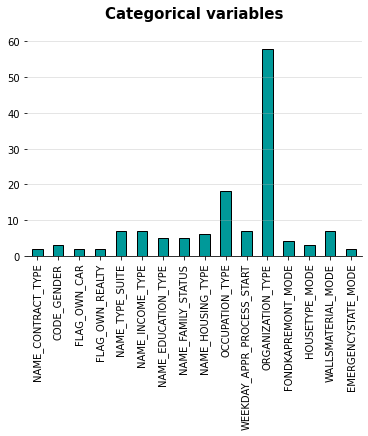

In [19]:
# Original code from https://github.com/Deep-dive-into-Kaggle-and-ML/Kaggle/blob/main/week08/Hyewon/Modeling.ipynb
ax = train_poly.select_dtypes('object').nunique().plot.bar(color = '#009999', edgecolor = 'k')

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('Categorical variables', fontweight= 'bold', fontsize = 15, pad = 20)
plt.show()

In [183]:
def polynomial_features_generator(raw, poly_features, n):
    '''
    Input data raw에 대해 n승의 polynomial feature들을 생성한다.
    '''
    raw_with_poly_features = raw[poly_features]
    imputer = SimpleImputer(strategy='median')
    poly_transformer = PolynomialFeatures(degree=n)
    
    
    if 'TARGET' in raw: # Train data
        raw_train = raw.copy()
        train_poly_features = raw_with_poly_features
        train_poly_features = imputer.fit_transform(train_poly_features)
        poly_transformer.fit(train_poly_features)
        train_poly_features = poly_transformer.transform(train_poly_features)
        train_poly_features = pd.DataFrame(train_poly_features, columns=poly_transformer.get_feature_names(poly_features))
        train_poly = raw_train.merge(train_poly_features)
        print('Shape of generated polynomial features on training data :', train_poly_features.shape)
        return train_poly

    
    else: # Test data
        raw_test = raw.copy()
        test_poly_features = imputer.fit_transform(raw_with_poly_features)
        poly_transformer.fit(test_poly_features)
        test_poly_features = poly_transformer.transform(test_poly_features)
        test_poly_features = pd.DataFrame(test_poly_features, columns=poly_transformer.get_feature_names(poly_features))
        test_poly = raw_test.merge(test_poly_features)
        print('Shape of generated polynomial features on testing data :', test_poly_features.shape)
        return test_poly

In [289]:
poly_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
poly_train = polynomial_features_generator(raw_train, poly_features, 3)
poly_test = polynomial_features_generator(raw_test, poly_features, 3)

Shape of generated polynomial features on training data : (307511, 35)
Shape of generated polynomial features on testing data : (48744, 35)


In [262]:
def label_encoder(raw, threshold):
    '''
    전체 변수 중 특정 threshold 이상의 범주 개수를 가지고 있는 변수에 대해 label encode를 수행한다.
    '''
    label_encode = pd.DataFrame()
    le = LabelEncoder()
    threshold_tf = raw.select_dtypes('object').nunique() > threshold
    label_encode_columns = [threshold_tf.index[i] for (i, name) in enumerate(threshold_tf) if name==True]
    for col in label_encode_columns:
        le_result = pd.DataFrame(le.fit_transform(raw[col]))
        label_encode = pd.concat([label_encode, le_result], axis=1)
    label_encode.columns = label_encode_columns
    return label_encode

In [294]:
label_encode_train = label_encoder(raw_train, 2)
label_encode_test = label_encoder(raw_test, 2)

In [287]:
def one_hot_encoder(raw, threshold):
    one_hot_encode = pd.DataFrame()
    threshold_tf = raw.select_dtypes('object').nunique() == threshold
    one_hot_encode_columns = [threshold_tf.index[i] for (i, name) in enumerate(threshold_tf) if name==True]
    for col in one_hot_encode_columns:
        oh_result = pd.get_dummies(raw[col])
        one_hot_encode = pd.concat([one_hot_encode, oh_result], axis=1)
    return one_hot_encode

In [295]:
one_hot_encode_train = one_hot_encoder(raw_train, 2)
one_hot_encode_test = one_hot_encoder(raw_test, 2)

In [ ]:
raw_train.select_dtypes('object').nunique()==2

In [304]:
one_hot_encode_train.columns = ['NAME_CONTRACT_TYPE_CASH_LOANS', 'NAME_CONTRACT_TYPE_REVOLVING_LOANS',
                                'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y',
                               'FLAG_OWN_REALITY_N', 'FLAG_OWN_REALITY_Y',
                               'EMERGENCYSTATE_MODE_N', 'EMERGENCYSTATE_MODE_Y']
one_hot_encode_train

,NAME_CONTRACT_TYPE_CASH_LOANS,NAME_CONTRACT_TYPE_REVOLVING_LOANS,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALITY_N,FLAG_OWN_REALITY_Y,EMERGENCYSTATE_MODE_N,EMERGENCYSTATE_MODE_Y
0,1,0,1,0,0,1,1,0
1,1,0,1,0,1,0,1,0
2,0,1,0,1,0,1,0,0
3,1,0,1,0,0,1,0,0
4,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
307506,1,0,1,0,1,0,1,0
307507,1,0,1,0,0,1,1,0
307508,1,0,1,0,0,1,1,0
307509,1,0,1,0,0,1,1,0


In [308]:
raw_test.select_dtypes('object').nunique()==2

NAME_CONTRACT_TYPE             True
CODE_GENDER                    True
FLAG_OWN_CAR                   True
FLAG_OWN_REALTY                True
NAME_TYPE_SUITE               False
NAME_INCOME_TYPE              False
NAME_EDUCATION_TYPE           False
NAME_FAMILY_STATUS            False
NAME_HOUSING_TYPE             False
OCCUPATION_TYPE               False
WEEKDAY_APPR_PROCESS_START    False
ORGANIZATION_TYPE             False
FONDKAPREMONT_MODE            False
HOUSETYPE_MODE                False
WALLSMATERIAL_MODE            False
EMERGENCYSTATE_MODE            True
dtype: bool

In [309]:
one_hot_encode_test.columns = ['NAME_CONTRACT_TYPE_CASH_LOANS', 'NAME_CONTRACT_TYPE_REVOLVING_LOANS',
                              'CODE_GENDER_F', 'CODE_GENDER_M',
                              'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y',
                              'FLAG_OWN_REALITY_N', 'FLAG_OWN_REALITY_Y',
                              'EMERGENCYSTATE_MODE_N', 'EMERGENCYSTATE_MODE_Y']
one_hot_encode_test

,NAME_CONTRACT_TYPE_CASH_LOANS,NAME_CONTRACT_TYPE_REVOLVING_LOANS,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALITY_N,FLAG_OWN_REALITY_Y,EMERGENCYSTATE_MODE_N,EMERGENCYSTATE_MODE_Y
0,1,0,1,0,1,0,0,1,1,0
1,1,0,0,1,1,0,0,1,0,0
2,1,0,0,1,0,1,0,1,0,0
3,1,0,1,0,1,0,0,1,1,0
4,1,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
48739,1,0,1,0,1,0,0,1,0,0
48740,1,0,1,0,1,0,1,0,0,0
48741,1,0,1,0,0,1,0,1,1,0
48742,1,0,0,1,1,0,1,0,1,0


In [310]:
train = pd.concat([poly_train, label_encode_train, one_hot_encode_train], axis=1)

In [312]:
test = pd.concat([poly_test, label_encode_test, one_hot_encode_test], axis=1)